# EPA API

# Details

https://aqs.epa.gov/aqsweb/documents/codetables/states_and_counties.html


In [3]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_theme()

In [4]:
# API configuration
BASE_URL = "https://aqs.epa.gov/data/api/dailyData/bySite"
EMAIL = "mrcodebastian@gmail.com"
API_KEY = "aquakit89"

In [5]:
# Cities and parameters
CITIES = [
    {"name": "New York", "state": "36", "county": "061", "site": "0110"},
    {"name": "Philadelphia", "state": "42", "county": "101", "site": "0004"},
    {"name": "Boston", "state": "25", "county": "025", "site": "0042"},
    {"name": "Washington DC", "state": "11", "county": "001", "site": "0043"}
]

PARAMS = {
    "44201": "Ozone",
    "42602": "Nitrogen dioxide (NO2)",
    "88101": "PM2.5 - Local Conditions",
    "42101": "Carbon monoxide"
}

In [6]:
# Date range
START_DATE = datetime(2023, 1, 1)  
END_DATE = datetime(2023, 12, 31)   

In [7]:
# Fetch
def get_air_quality_data(city, param):
    url = f"{BASE_URL}?email={EMAIL}&key={API_KEY}&param={param}&bdate={START_DATE.strftime('%Y%m%d')}&edate={END_DATE.strftime('%Y%m%d')}&state={city['state']}&county={city['county']}&site={city['site']}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error getting data for {city['name']}, parameter {param}: {str(e)}")
        return None

In [8]:
# Fetch each county
def main():
    all_data = {}
    for city in CITIES:
        print(f"\nFetching data for {city['name']}:")
        city_data = {}
        for param_code, param_name in PARAMS.items():
            data = get_air_quality_data(city, param_code)
            if data and 'Data' in data and data['Data']:
                filtered_data = [
                    {
                        'value': float(entry['arithmetic_mean']),
                        'units': entry['units_of_measure'],
                        'date': entry['date_local']
                    }
                    for entry in data['Data']
                ]
                city_data[param_name] = filtered_data
                print(f"  Retrieved {len(filtered_data)} data points for {param_name}")
            else:
                print(f"  No data for {param_name}")
        all_data[city['name']] = city_data
    return all_data

if __name__ == "__main__":
    results = main()


Fetching data for New York:
  No data for Ozone
  No data for Nitrogen dioxide (NO2)
  No data for PM2.5 - Local Conditions
  No data for Carbon monoxide

Fetching data for Philadelphia:
  Retrieved 1475 data points for Ozone
  No data for Nitrogen dioxide (NO2)
  Retrieved 4882 data points for PM2.5 - Local Conditions
  No data for Carbon monoxide

Fetching data for Boston:
  Retrieved 1393 data points for Ozone
  Retrieved 628 data points for Nitrogen dioxide (NO2)
  Retrieved 6095 data points for PM2.5 - Local Conditions
  Retrieved 682 data points for Carbon monoxide

Fetching data for Washington DC:
  Retrieved 1484 data points for Ozone
  Retrieved 1448 data points for Nitrogen dioxide (NO2)
  Retrieved 4389 data points for PM2.5 - Local Conditions
  Retrieved 730 data points for Carbon monoxide


In [9]:
# New york Data fails to load even though correct, will have to disregard and move on, likely archive data via CSV

In [10]:
# Convert the data to a pandas DataFrame for easy analysis
df = pd.DataFrame([
        (city, param, entry['value'], entry['units'], entry['date'])
        for city, params in results.items()
        for param, data in params.items() if data is not None
        for entry in data
    ], columns=['City', 'Parameter', 'Value', 'Units', 'Date'])

In [11]:
df.to_csv('EPAresults.csv', index=False)
df

,City,Parameter,Value,Units,Date
0,Philadelphia,Ozone,0.010957,Parts per million,2023-01-01
1,Philadelphia,Ozone,0.010292,Parts per million,2023-01-01
2,Philadelphia,Ozone,0.010292,Parts per million,2023-01-01
3,Philadelphia,Ozone,0.010529,Parts per million,2023-01-01
4,Philadelphia,Ozone,0.002542,Parts per million,2023-01-02
...,...,...,...,...,...
23201,Washington DC,Carbon monoxide,0.212500,Parts per million,2023-12-29
23202,Washington DC,Carbon monoxide,0.226042,Parts per million,2023-12-30
23203,Washington DC,Carbon monoxide,0.200000,Parts per million,2023-12-30
23204,Washington DC,Carbon monoxide,0.225304,Parts per million,2023-12-31


In [12]:
# import
df = pd.read_csv('EPAresults.csv')

In [13]:
df.columns

Index(['City', 'Parameter', 'Value', 'Units', 'Date'], dtype='object')

In [14]:
df.value_counts()

City           Parameter                 Value      Units                        Date      
Washington DC  PM2.5 - Local Conditions  36.500000  Micrograms/cubic meter (LC)  2023-06-28    16
                                         37.400000  Micrograms/cubic meter (LC)  2023-06-30    16
                                         5.700000   Micrograms/cubic meter (LC)  2023-06-27    16
                                         27.600000  Micrograms/cubic meter (LC)  2023-07-01    16
Boston         PM2.5 - Local Conditions  5.000000   Micrograms/cubic meter (LC)  2023-03-31    16
                                                                                               ..
               Ozone                     0.029304   Parts per million            2023-02-21     1
Philadelphia   PM2.5 - Local Conditions  28.250000  Micrograms/cubic meter (LC)  2023-07-18     1
Boston         Ozone                     0.029375   Parts per million            2023-05-02     1
Philadelphia   PM2.5 - Loc

In [15]:
# 'Date' column to datetime 
df['Date'] = pd.to_datetime(df['Date'])

In [16]:
# Cities exceeding PM2.5 daily standard
pm25_excess = df[(df['Parameter'] == 'PM2.5 - Local Conditions') & (df['Value'] > 35)]
print("Cities exceeding PM2.5 daily standard:")
print(pm25_excess[['City', 'Value', 'Units', 'Date']])

Cities exceeding PM2.5 daily standard:
                City      Value                        Units       Date
3035    Philadelphia  58.916667  Micrograms/cubic meter (LC) 2023-06-06
3036    Philadelphia  58.916667  Micrograms/cubic meter (LC) 2023-06-06
3037    Philadelphia  58.900000  Micrograms/cubic meter (LC) 2023-06-06
3038    Philadelphia  58.900000  Micrograms/cubic meter (LC) 2023-06-06
3039    Philadelphia  58.900000  Micrograms/cubic meter (LC) 2023-06-06
...              ...        ...                          ...        ...
21951  Washington DC  81.100000  Micrograms/cubic meter (LC) 2023-06-29
21952  Washington DC  81.100000  Micrograms/cubic meter (LC) 2023-06-29
21953  Washington DC  81.100000  Micrograms/cubic meter (LC) 2023-06-29
21954  Washington DC  81.100000  Micrograms/cubic meter (LC) 2023-06-29
21955  Washington DC  81.100000  Micrograms/cubic meter (LC) 2023-06-29

[210 rows x 4 columns]


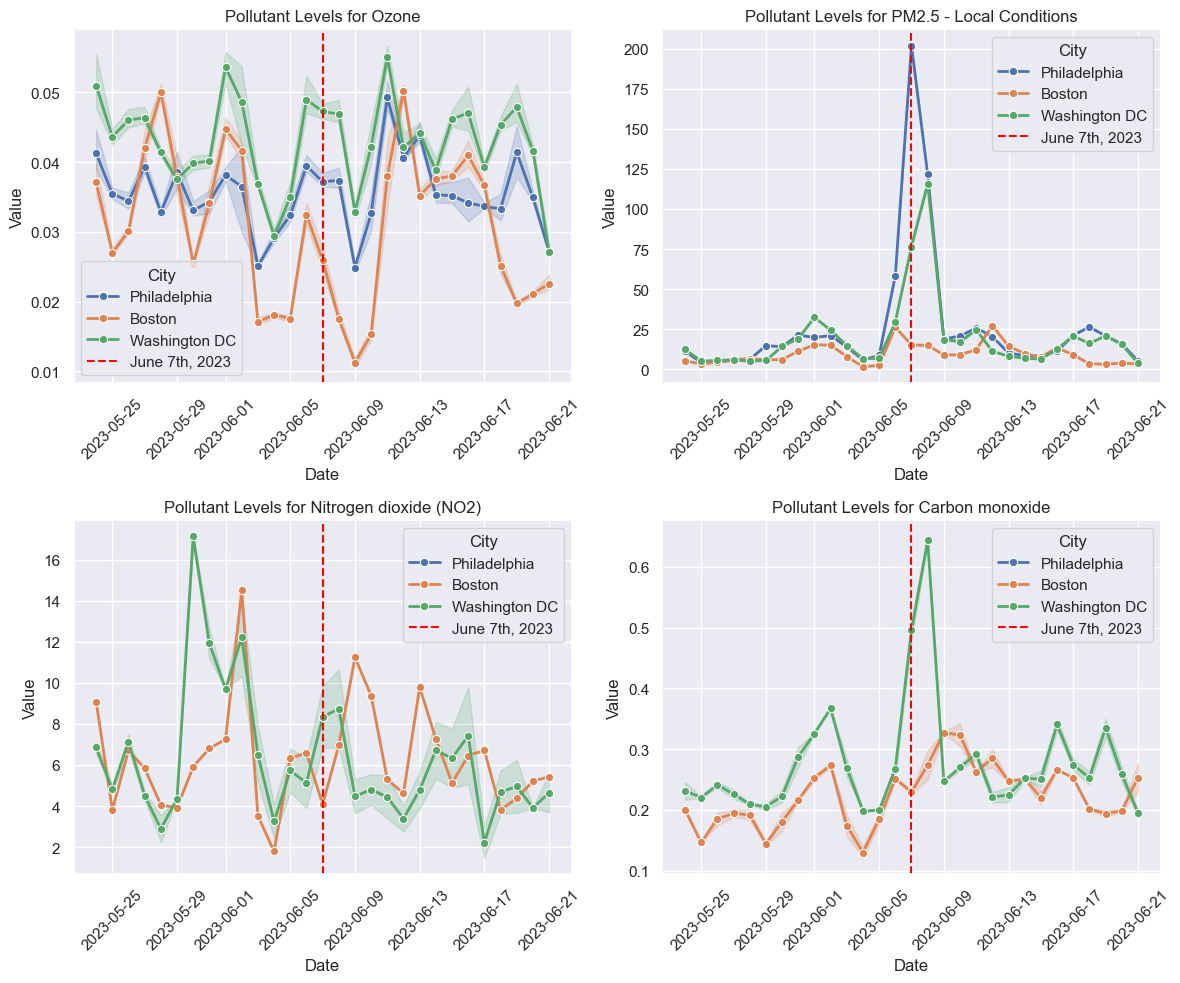

In [17]:
# Define date range
start_date = pd.Timestamp('2023-05-24')  # Two weeks before June 7th
end_date = pd.Timestamp('2023-06-21')    # Two weeks after June 7th

# Filter data within the date range
data_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
parameters = data_data['Parameter'].unique()
cities = data_data['City'].unique()  # Get unique cities
vertical_line_date = pd.Timestamp('2023-06-07')

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through each parameter and create a line plot in the corresponding subplot
for i, param in enumerate(parameters):
    for city in cities:
        param_city_data = data_data[(data_data['Parameter'] == param) & (data_data['City'] == city)]
        sns.lineplot(data=param_city_data, x='Date', y='Value', marker='o', linewidth=2, ax=axs[i], label=city)
    
    axs[i].set_title(f'Pollutant Levels for {param}')
    axs[i].axvline(x=vertical_line_date, color='red', linestyle='--', label='June 7th, 2023')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend(title='City')  # Show legend to include city labels

# Adjust layout
plt.tight_layout()
plt.show()

### Pollutant Levels Over Time: 
Each plot shows how the level of a pollutant changed over time. 

### Shaded Regions Indicating Uncertainty or Variability: 
The shaded regions around the line plots likely represent some measure of variability (e.g., standard deviation or confidence interval) around the daily pollutant measurements.

In [19]:
# Define the date ranges for the two-week periods before and after June 7th, 2023
before_start_date = pd.Timestamp('2023-05-24')
before_end_date = pd.Timestamp('2023-06-06')
after_start_date = pd.Timestamp('2023-06-08')
after_end_date = pd.Timestamp('2023-06-21')

# Filter data for the two periods
before_data = df[(df['Date'] >= before_start_date) & (df['Date'] <= before_end_date)]
after_data = df[(df['Date'] >= after_start_date) & (df['Date'] <= after_end_date)]

# Group by City and Parameter to calculate mean pollutant levels before and after June 7th
mean_before = before_data.groupby(['City', 'Parameter'])['Value'].mean().reset_index()
mean_after = after_data.groupby(['City', 'Parameter'])['Value'].mean().reset_index()

change_data = pd.merge(mean_before, mean_after, on=['City', 'Parameter'], suffixes=('_before', '_after'))

# Calculate the absolute and percentage change
change_data['Absolute Change'] = change_data['Value_after'] - change_data['Value_before']
change_data['Percentage Change (%)'] = (change_data['Absolute Change'] / change_data['Value_before']) * 100
print(change_data)

            City                 Parameter  Value_before  Value_after  \
0         Boston           Carbon monoxide      0.194656     0.253924   
1         Boston    Nitrogen dioxide (NO2)      6.148980     6.545493   
2         Boston                     Ozone      0.032503     0.029223   
3         Boston  PM2.5 - Local Conditions      8.140954    10.148679   
4   Philadelphia                     Ozone      0.035240     0.035969   
5   Philadelphia  PM2.5 - Local Conditions     15.089270    24.901585   
6  Washington DC           Carbon monoxide      0.247803     0.289761   
7  Washington DC    Nitrogen dioxide (NO2)      6.918604     5.104924   
8  Washington DC                     Ozone      0.043673     0.042602   
9  Washington DC  PM2.5 - Local Conditions     14.176567    26.849339   

   Absolute Change  Percentage Change (%)  
0         0.059268              30.447565  
1         0.396514               6.448444  
2        -0.003279             -10.089806  
3         2.007726  

In [20]:
change_data.to_csv('Pollutant_Level_Changes.csv', index=False)

## Boston:
- Carbon monoxide increased by approximately 30.4%.
- Nitrogen dioxide (NO2) had a smaller increase of around 6.4%.
- Ozone levels decreased by about 10.1%.
- PM2.5 - Local Conditions increased by 24.7%.

## Philadelphia:
- Ozone saw a slight increase of around 2.1%.
- PM2.5 - Local Conditions had a significant rise of about 65.0%.

## Washington DC:
- Carbon monoxide increased by 16.9%.
- Nitrogen dioxide (NO2) decreased significantly by 26.2%.
- Ozone had a minor decrease of 2.5%.
- PM2.5 - Local Conditions saw a large increase of 89.4%.
- Significant Increases and Decreases:

The most significant increases were observed in PM2.5 levels in Washington DC (89.4%) and Philadelphia (65.0%), which suggests a strong impact from the event around June 7, 2023.
Notable decreases were seen in Nitrogen dioxide (NO2) in Washington DC (-26.2%) and Ozone in Boston (-10.1%), indicating that these pollutants did not increase in response to the wildfire event, or perhaps affected differently.

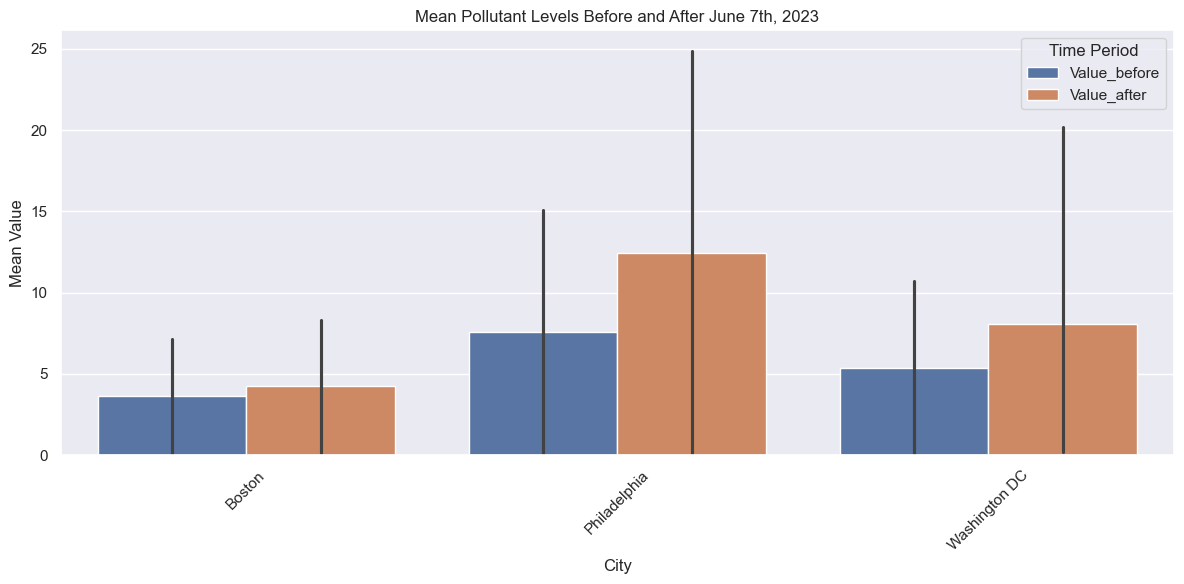

In [27]:
change_data_melted = change_data.melt(id_vars=['City', 'Parameter'], 
                                        value_vars=['Value_before', 'Value_after'], 
                                        var_name='Time Period', 
                                        value_name='Mean Value')
# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=change_data_melted, x='City', y='Mean Value', hue='Time Period')
plt.title('Mean Pollutant Levels Before and After June 7th, 2023')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.legend(title='Time Period')
plt.tight_layout()
plt.show()

In [ ]:
# bar plot that compares the mean pollutant levels before and after the specified date for each city.

### GAVE ME LIMITED INFORMATION, USE DOWNLOADED DATA SET TO CONTINUE FINDINGS 